# Digit Recognizer
## Learn computer vision fundamentals with the famous MNIST data

In [ ]:
import numpy as np
import pandas as pd
import zipfile
from keras.utils import np_utils

In [2]:
zip_name = 'digit-recognizer.zip'
zf = zipfile.ZipFile(zip_name) 
data_train = pd.read_csv(zf.open('train.csv', mode='r'))

In [85]:
X_test = pd.read_csv(zf.open('test.csv', mode='r'))

In [86]:
X_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
submission_example = pd.read_csv(zf.open('sample_submission.csv', mode='r'))

In [88]:
submission_example.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [89]:
X_train, y_train = data_train.drop(columns='label'), data_train.label

In [90]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)

In [91]:
X_train = X_train.astype("float32")
X_train /= 255
Y_train = np_utils.to_categorical(y_train, 10)

X_test = X_test.astype("float32")
X_test /= 255


## Визуализируем цифры

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.size'] = 20   
def show_digits(images_array, image_labels, predictions, indices = range(5)):
    columns = 5
    rows = len(indices)//columns + (0 if len(indices)%columns == 0 else 1)        
    fig = plt.figure(figsize=(25, 25))        
    for i, ind in enumerate(indices):    
        ax = fig.add_subplot(rows, columns, i+1)      
        image = np.reshape(images_array[ind], [28, 28])
        str_title = "Label:" + str(np.argmax(image_labels[ind])) + " Prediction:" + str(np.argmax(predictions[ind]))
        ax.set_title(str_title)
        plt.imshow(image)    
    plt.tight_layout()
    plt.show()

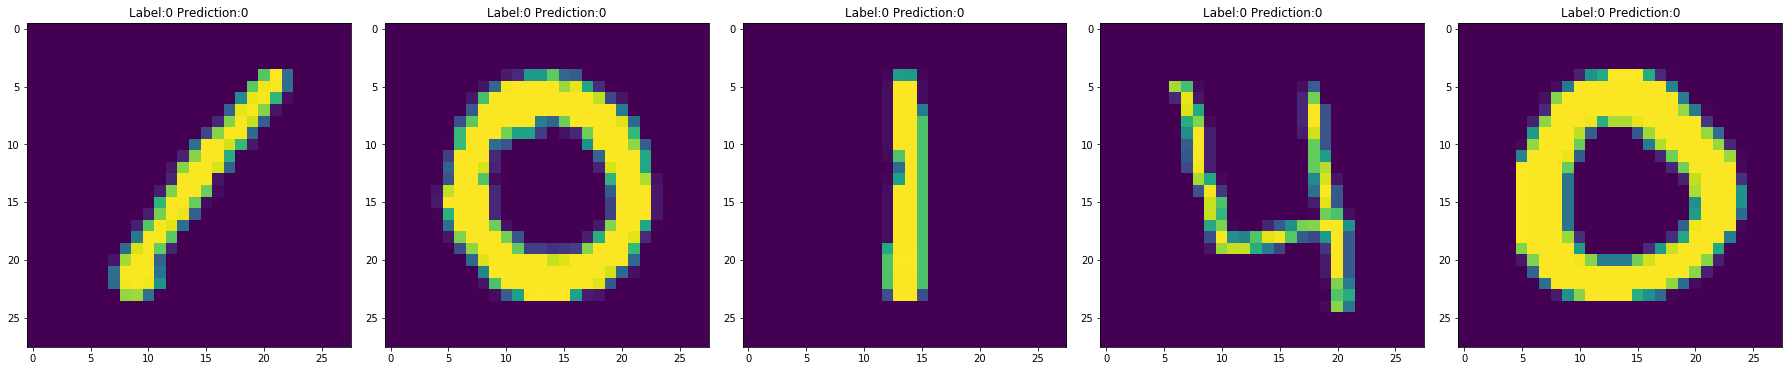

In [9]:
show_digits(X_train, y_train, y_train)

## Сверточная сеть на чистом TensorFlow

In [10]:
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

Входные данные для двумерной свертки в TensoFlow должны иметь четырехмерную структуру, которая выглядит так:
$$[размер \: батча, \: высота, \: ширина, \: каналы]$$

А размерность тензора сверточных весов определяется размерами ядра свертки и числом каналов как на входе, так и на выходе. Получается снова четырехмерный тензор, но уже следующего вида:
$$[высота, \: ширина, \: входные \: каналы, \: выходные \: каналы]$$

Будем использовать 32 различных ядер свертки одного размера 5х5.

In [11]:
x_image = tf.reshape(x, [-1, 28, 28, 1])
W_conv_1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv_1 = tf.Variable(tf.constant(0.1, shape=[32]))

Здесь $-1$ в `tf.reshape(x, [-1, 28, 28, 1])` означает заранее неизвестный размер мини-батча. А последняя единичка говорит нам о том, что канал всего лишь один, т.е. наши изображения монохромные. 

Теперь у нас определены переменные для всех весов сверточного слоя. Используем функцию `tf.nn.conv2d` для применения сверточных фильтров. Аргумент `strides` задает шаг по изображению. Зададим шаг 1 по всем размерностям. Аргумент `padding` говорит как быть с окнами, которые "вылезают" за границы входного массива.

In [12]:
conv_1 = tf.nn.conv2d(x_image, W_conv_1, strides=[1, 1, 1, 1], padding="SAME") + b_conv_1

В качестве функции активации возьмем ReLU

In [13]:
h_conv_1 = tf.nn.relu(conv_1)

Итак, слой фильтров с нелинейностью готов. Осталось только добавить слой субдискретизации (pooling). Обычно в качестве операции субдискретизации к каждой локальной группе нейронов применяется операция взятия максимума (max-pooling). 

Хотя в результате субдискретизации теряется часть информации, сеть становится более устойчивой к небольшим трансформациям изображения вроде сдвига и поворота. Параметр `ksize` задает размер окна субдискретизации по всем четыремя размерностям.

In [14]:
h_pool_1 = tf.nn.max_pool(h_conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

Параметры `strides` и `padding`означают здесь то же самое, что в сверточном слое, только в этот раз мы двигаемся по изображению в обе стороны с шагом 2. Понятно, что после этого слоя размер изображения в обоиз направления уменьшится вдвое, до 14х14.

Теперь давайте добавим еще один сверточный слой и слой субдискретизации, в этот раз используем на этом слое 64 фильтра:


In [15]:
W_conv_2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv_2 = tf.Variable(tf.constant(0.1, shape=[64]))
conv_2 = tf.nn.conv2d(h_pool_1, W_conv_2, strides=[1, 1, 1, 1], padding="SAME") + b_conv_2

h_conv_2 = tf.nn.relu(conv_2)
h_pool_2 = tf.nn.max_pool(h_conv_2,  ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")#должно быть 7х7, но 14х14.Почему?

Как правило, в глубоких нейронных сетях за сверточным слоем следуют полносвязные, задача которых состоит в том, чтобы "собрать вместе" все признаки из фильтров и собственно перевести их в самый последний слой, который выдаст ответ. Но для начала нам нужно из двумерного слоя сделать плоский:

In [16]:
h_pool_2_flat = tf.reshape(h_pool_2, [-1, 7*7*64])

Число $7 \cdot  7 \cdot 64$ возникло из-за того, что мы дважды применили субдискретизацию и при этом в последнем слое использовали 64 фильтра. И теперь осталось только добавить полносвязные слои. Добавляем первый слой из 1024 нейронов

In [17]:
W_fc_1 = tf.Variable(tf.truncated_normal([7*7*64, 1024], stddev=0.1))
b_fc_1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc_1 = tf.nn.relu(tf.matmul(h_pool_2_flat, W_fc_1) + b_fc_1)

Регуляризируем дропаутом:

In [18]:
keep_propability = tf.placeholder(tf.float32, name="keep_prob")
h_fc_1_drop = tf.nn.dropout(h_fc_1, keep_propability)

Теперь добавляем последний слой с десятью выходами:

In [19]:
W_fc_2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc_2 = tf.Variable(tf.constant(0.1, shape=[10]))

logit_conv = tf.matmul(h_fc_1_drop, W_fc_2) + b_fc_2
y_conv = tf.nn.softmax(logit_conv)

Осталось определить ошибку и ввести оптимизатор. Используем алгоритм адаптивного градиентонго спуска `Adam`. Его идея в том, что шаг изменения должен быть меньше у тех весов, котоыре в большей степени варьируются в данных, и больше у тех, которые менее изменчиввы в разных примерах.

In [20]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit_conv, labels=y))
train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

In [21]:
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [22]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [127]:
import numpy as np 
batch_size = 64
for i in range(10000):
    rand_indexes = np.random.choice(range(X_train.shape[0]), batch_size)
    batch_xs, batch_ys = X_train[rand_indexes].reshape(batch_size, 784), Y_train[rand_indexes].reshape(batch_size, 10)
    #batch_xs, batch_ys = mnist.train.next_batch(64)
    sess.run(train_step, feed_dict = {x:batch_xs, y:batch_ys, keep_propability:0.5})

In [128]:
error_rate_1 = sess.run(accuracy, feed_dict = {x: X_train.reshape(X_train.shape[0], 784)[:5000],
                                               y: Y_train.reshape(X_train.shape[0], 10)[:5000], keep_propability: 1.})

In [129]:
error_rate_1

0.999

## Prediction and write to csv

In [130]:
X_test.shape

(28000, 784)

In [131]:
predictions_prob = sess.run(y_conv, feed_dict={x: X_test[:5000], keep_propability: 1.})

In [132]:
predictions = np.argmax(prdeictions_prob, axis=1)

In [133]:
predictions.shape

(5000,)

In [134]:
answer = pd.DataFrame()

In [135]:
for i in range(0, 5):
    predictions = np.argmax(sess.run(y_conv, feed_dict={x: X_test[i*5000:(i+1)*5000], keep_propability: 1.}), axis=1)
    tmp = pd.DataFrame({'ImageId': range(1 + i*(5000), 1+ 5000*(i+1)), 'Label': predictions})
    answer = answer.append(tmp)

In [136]:
predictions = np.argmax(sess.run(y_conv, feed_dict={x: X_test[25000:], keep_propability: 1.}), axis=1)

In [137]:
tmp = pd.DataFrame({'ImageId': range(25001, 28001), 'Label': predictions})
answer = answer.append(tmp)

In [138]:
answer.to_csv('ans_digit_recon.csv', index=False)

In [139]:
answer2 = pd.read_csv('ans_digit_recon.csv')
answer2.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


## Сверточная сеть на Keras

In [140]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D, Conv2D

In [141]:
batch_size, img_rows, img_cols = 64, 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype("float32")
X_train /= 255
Y_train = np_utils.to_categorical(y_train, 10)

X_test = X_test.astype("float32")
X_test /= 255

In [142]:
model = Sequential()

model.add(Conv2D(32, (5, 5),  input_shape=input_shape, padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Conv2D(64, (5, 5), padding="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

In [143]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [145]:
from keras.callbacks import ModelCheckpoint
model.fit(X_train, Y_train, 
          callbacks=[ModelCheckpoint("model.hdf5", monitor="val_acc",
                                     save_best_only=True, save_weights_only=False, mode="auto")],
          validation_split=0.1, epochs=100, batch_size=64)

Train on 37800 samples, validate on 4200 samples
Epoch 1/100
37800/37800 [==============================] - 44s 1ms/step - loss: 0.0529 - acc: 0.9833 - val_loss: 0.0459 - val_acc: 0.9845
Epoch 2/100
37800/37800 [==============================] - 46s 1ms/step - loss: 0.0498 - acc: 0.9843 - val_loss: 0.0447 - val_acc: 0.9845
Epoch 3/100
37800/37800 [==============================] - 48s 1ms/step - loss: 0.0454 - acc: 0.9857 - val_loss: 0.0425 - val_acc: 0.9838
Epoch 4/100
37800/37800 [==============================] - 45s 1ms/step - loss: 0.0441 - acc: 0.9857 - val_loss: 0.0383 - val_acc: 0.9874
Epoch 5/100
37800/37800 [==============================] - 45s 1ms/step - loss: 0.0404 - acc: 0.9864 - val_loss: 0.0421 - val_acc: 0.9838
Epoch 6/100
37800/37800 [==============================] - 45s 1ms/step - loss: 0.0365 - acc: 0.9882 - val_loss: 0.0380 - val_acc: 0.9876
Epoch 7/100
37800/37800 [==============================] - 45s 1ms/step - loss: 0.0354 - acc: 0.9884 - val_loss: 0.0354 - v

## Plot the loss and accuracy curves for training and validation 

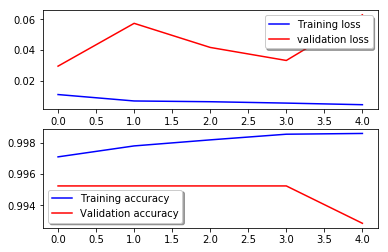

In [185]:
fig, ax = plt.subplots(2,1)

ax[0].plot(model.history.history['loss'], color='b', label="Training loss")
ax[0].plot(model.history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(model.history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(model.history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## kaggle write answer

In [161]:
model.fit(X_train, Y_train, 
          callbacks=[ModelCheckpoint("model.hdf5", monitor="val_acc",
                                     save_best_only=True, save_weights_only=False, mode="auto")],
          validation_split=0.01, epochs=5, batch_size=64)

Train on 41580 samples, validate on 420 samples
Epoch 1/5
41580/41580 [==============================] - 47s 1ms/step - loss: 0.0110 - acc: 0.9971 - val_loss: 0.0295 - val_acc: 0.9952
Epoch 2/5
41580/41580 [==============================] - 48s 1ms/step - loss: 0.0068 - acc: 0.9978 - val_loss: 0.0573 - val_acc: 0.9952
Epoch 3/5
41580/41580 [==============================] - 49s 1ms/step - loss: 0.0063 - acc: 0.9982 - val_loss: 0.0416 - val_acc: 0.9952
Epoch 4/5
41580/41580 [==============================] - 49s 1ms/step - loss: 0.0054 - acc: 0.9985 - val_loss: 0.0332 - val_acc: 0.9952
Epoch 5/5
41580/41580 [==============================] - 48s 1ms/step - loss: 0.0044 - acc: 0.9986 - val_loss: 0.0628 - val_acc: 0.9929


## Сохраним модель в файл

In [178]:
from keras.models import load_model

# model.save('digits_recognition_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('my_model.h5')

## Запись ответов в файл

In [162]:
predictions = model.predict(X_test)

In [163]:
predictions = np.argmax(predictions, axis=1)

In [164]:
ans_df = pd.DataFrame({'ImageId': range(1, 28001), 'Label': predictions})
ans_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [165]:
ans_df.to_csv('ans_digit_recon2.csv', index=False)

In [167]:
pd.read_csv('ans_digit_recon2.csv').head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


NameError: name 'itertools' is not defined

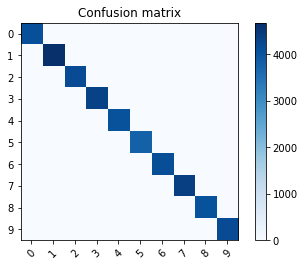

In [175]:
# Look at confusion matrix 
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_train)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_train, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
confusion_mtx
# plot the confusion matrix
#plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [ ]:
Y_pred = model.predict(X_test)

Найдем сколько цифр было распознано ошибочно.

In [176]:
0.9986*X_train.shape[0]

41941.200000000004

In [177]:
X_train.shape[0] - 0.9986*X_train.shape[0]

58.799999999995634